<a href="https://colab.research.google.com/github/blancavazquez/CursoDatosMasivosII/blob/2023-I/notebooks/6b_spectral_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamiento espectral
En esta libreta programaremos el método de agrupamiento espectral y lo aplicaremos al descubrimiento de comunidades en redes sociales.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans, SpectralClustering

np.random.seed(2022)
n_componentes = 4

## Grafo simple
Empezamos creando un grafo simple, del cual analizaremos el [espectro](https://en.wikipedia.org/wiki/Spectrum_of_a_matrix) de su matriz laplaciana.

In [2]:
G_simple = nx.Graph()
G_simple.add_nodes_from(range(10))
acom1 = [(i,j)for i in range(4) for j in range(4) if i != j]
acom2 = [(i,j)for i in range(4,8) for j in range(4,8) if i != j]
acom3 = [(i,j)for i in range(8,12) for j in range(8,12) if i != j]
G_simple.add_edges_from(acom1)
G_simple.add_edges_from(acom2)
G_simple.add_edges_from(acom3)
G_simple.add_edge(3,4)
G_simple.add_edge(2,5)
G_simple.add_edge(6,8)
G_simple.add_edge(7,9)
G_simple.add_edge(10,12)
G_simple.add_edge(11,12)
G_simple.add_edge(12,13)

Visualizamos el grafo creado.

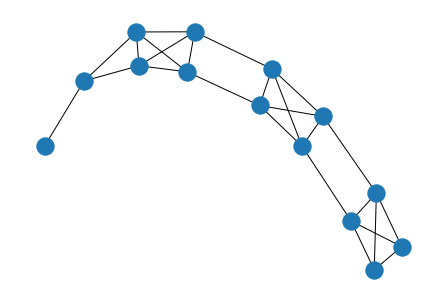

In [3]:
simple_pos = nx.spring_layout(G_simple)
nx.draw(G_simple, pos=simple_pos)

Obtenemos y desplegamos la matriz de adyacencia del grafo.

In [4]:
amat_simple = nx.linalg.adjacency_matrix(G_simple)
print(amat_simple.toarray())

[[0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 1 1 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


Hacemos lo propio con la matriz de grado.

In [5]:
dmat_simple = np.diag(nx.linalg.laplacian_matrix(G_simple).diagonal())
print(dmat_simple)
print(dmat_simple.diagonal())

[[3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
[3 3 4 4 4 4 4 4 4 4 4 4 3 1]


Finalmente obtenemos y desplegamos la matriz laplaciana.

In [6]:
lmat_simple = nx.linalg.laplacian_matrix(G_simple)
print(lmat_simple.toarray())

[[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  4 -1  0 -1  0  0  0  0  0  0  0  0]
 [-1 -1 -1  4 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  4 -1 -1 -1  0  0  0  0  0  0]
 [ 0  0 -1  0 -1  4 -1 -1  0  0  0  0  0  0]
 [ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
 [ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
 [ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
 [ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0]
 [ 0  0  0  0  0  0  0  0 -1 -1 -1  4 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  1]]


Calculamos los vectores y valores propios de la matriz laplaciana.

In [7]:
lmat_simple_sp= sp.sparse.csgraph.laplacian(amat_simple)
print(lmat_simple_sp.toarray())

[[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
 [-1 -1  4 -1  0 -1  0  0  0  0  0  0  0  0]
 [-1 -1 -1  4 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  4 -1 -1 -1  0  0  0  0  0  0]
 [ 0  0 -1  0 -1  4 -1 -1  0  0  0  0  0  0]
 [ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
 [ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
 [ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
 [ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0]
 [ 0  0  0  0  0  0  0  0 -1 -1 -1  4 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  1]]


In [8]:
eval_simple, evec_simple = sp.sparse.linalg.eigsh(lmat_simple.astype(np.float64),
                                                  sigma=1.0, 
                                                  which="LM",
                                                  tol=0.0,
                                                  v0= np.random.uniform(-1, 1, size=lmat_simple.shape[0]))

In [9]:
print(evec_simple[:, 1])
print(np.sort(evec_simple[:, 1]))

[ 0.34711725  0.34711725  0.30359599  0.30359599  0.14042428  0.14042428
  0.04123215  0.04123215 -0.16749141 -0.16749141 -0.25085327 -0.25085327
 -0.35467345 -0.47337651]
[-0.47337651 -0.35467345 -0.25085327 -0.25085327 -0.16749141 -0.16749141
  0.04123215  0.04123215  0.14042428  0.14042428  0.30359599  0.30359599
  0.34711725  0.34711725]


Verificamos que las restricciones se están cumpliendo.

In [10]:
print(np.sum(evec_simple**2, axis=0))
print(np.sum(evec_simple, axis=0))

[1. 1. 1. 1. 1. 1.]
[ 3.74165739e+00 -1.77635684e-15  6.66133815e-16  1.11022302e-16
 -5.55111512e-16 -1.00613962e-16]


Ordenamos los valores propios de menor a mayor y mantenemos el mismo orden para los vectores propios correspondientes.

In [11]:
orden_idx = np.argsort(eval_simple)
eval_simple = eval_simple[orden_idx]
evec_simple = evec_simple[:, orden_idx]

Examinamos los valores propios ordenados.

In [12]:
print(eval_simple)

[-2.22044605e-16  2.50758251e-01  7.63932023e-01  1.37332602e+00
  3.24376387e+00  4.00000000e+00]


Desplegamos el primer valor propio y su correspondiente vector propio. Nota que el valor propio más pequeño $\approx 0$ y que todos los elementos de su vector propio correspondiente son iguales.

In [13]:
print(eval_simple[0])
print(evec_simple[:, 0])

-2.220446049250313e-16
[0.26726124 0.26726124 0.26726124 0.26726124 0.26726124 0.26726124
 0.26726124 0.26726124 0.26726124 0.26726124 0.26726124 0.26726124
 0.26726124 0.26726124]


Visualizamos los elementos de los vectores propios con valor propio más pequeño.

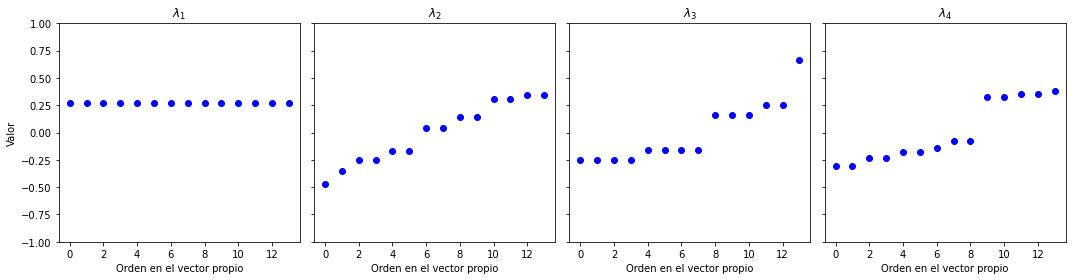

In [14]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

for i in range(4):
  axs[i].plot(np.sort(evec_simple[:, i]), 'bo')
  axs[i].set_ylim([-1,1])
  axs[i].set_xlabel('Orden en el vector propio')
  axs[i].set_title('$\\lambda_' + str(i + 1) + '$')

axs[0].set_ylabel('Valor')
fig.tight_layout()
plt.show()

Empleamos KMeans para agrupar los nodos usando los eigenvalores asociados.

In [15]:
km_simple = KMeans(n_clusters=3, n_init=100)
km_simple = km_simple.fit(evec_simple[:, 1:])
km_simple.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0], dtype=int32)

In [16]:
print(G_simple.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


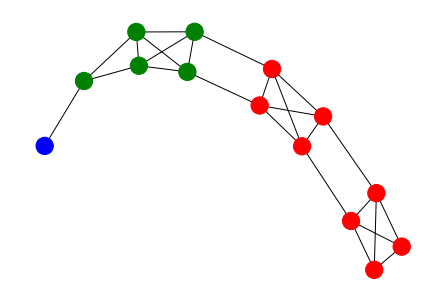

In [17]:
mapa_color = {0:'blue', 1:'red', 2:'green'}
color_vertices = [mapa_color[km_simple.labels_[n]] for n in G_simple]
nx.draw(G_simple, pos=simple_pos, node_color=color_vertices)

## Club de karate de Zachary
Hacemos el mismo análisis del grafo anterior usando el grafo del [Club de karate de Zachary](https://en.wikipedia.org/wiki/Zachary%27s_karate_club), el cual está disponible en la biblioteca NetworkX. 

Primero, cargamos y visualizamos el grafo.


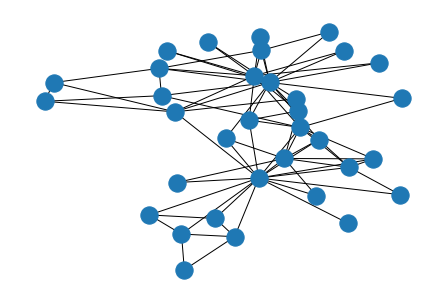

In [18]:
G_karate = nx.karate_club_graph()    
karate_pos = nx.spring_layout(G_karate)
nx.draw(G_karate)

Obtenemos su matriz de adyacencia y laplaciana.

In [19]:
lmat_karate = nx.linalg.laplacian_matrix(G_karate)
amat_karate = nx.linalg.adjacency_matrix(G_karate)
lmat_karate = lmat_karate.toarray()

In [20]:
amat_karate.toarray()

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

Calculamos los vectores y valores propios de la matriz lapaciana.

In [21]:
eval_karate, evec_karate = np.linalg.eigh(lmat_karate.astype(np.float64))

Examinamos sus propiedades.

In [22]:
print(np.sum(evec_karate**2, axis=0))
print(np.sum(evec_karate, axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 5.83095189e+00 -5.34294831e-15  1.57512892e-15 -1.42247325e-15
 -1.08246745e-15 -5.61183044e-16 -1.83013327e-15 -9.02056208e-16
  1.69395747e-15  2.67062958e-16  2.86579186e-17 -3.67887183e-17
 -9.87819220e-17  1.58141520e-16  1.83880688e-15 -1.46150453e-15
 -6.34908792e-16  5.96744876e-16  7.49400542e-16  9.00789248e-16
  9.43689571e-16 -2.53432258e-18  2.39391840e-16  5.03069808e-16
 -1.06772230e-15  6.47080178e-16  5.98479599e-17  1.38083989e-15
 -1.79717352e-15 -1.84574578e-15 -1.27675648e-15  1.90125693e-15
 -5.55111512e-16  2.22044605e-15]


Ordenamos los vectores propios en orden ascendente al valor propio asociado.

In [23]:
orden_idx = np.argsort(eval_karate)
eval_karate = eval_karate[orden_idx]
evec_karate = evec_karate[:, orden_idx]

Desplegamos los valores propios ordenados.

In [24]:
print(eval_karate)

[3.75064495e-16 4.68525227e-01 9.09247664e-01 1.12501072e+00
 1.25940411e+00 1.59928308e+00 1.76189862e+00 1.82605521e+00
 1.95505045e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
 2.00000000e+00 2.00000000e+00 2.48709173e+00 2.74915718e+00
 3.01396297e+00 3.24206748e+00 3.37615409e+00 3.38196601e+00
 3.47218740e+00 4.27587682e+00 4.48000767e+00 4.58079267e+00
 5.37859508e+00 5.61803399e+00 6.33159222e+00 6.51554463e+00
 6.99619703e+00 9.77724095e+00 1.09210675e+01 1.33061223e+01
 1.70551712e+01 1.81366960e+01]


Examinamos el vector propio asociado al valor propio más pequeño.

In [25]:
print(eval_karate[0])
print(evec_karate[:, 0])

3.750644949783097e-16
[0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859 0.17149859
 0.17149859 0.17149859 0.17149859 0.17149859]


Graficamos los elementos de los vectores propios asociados a los cuatro valores propios más pequeños.

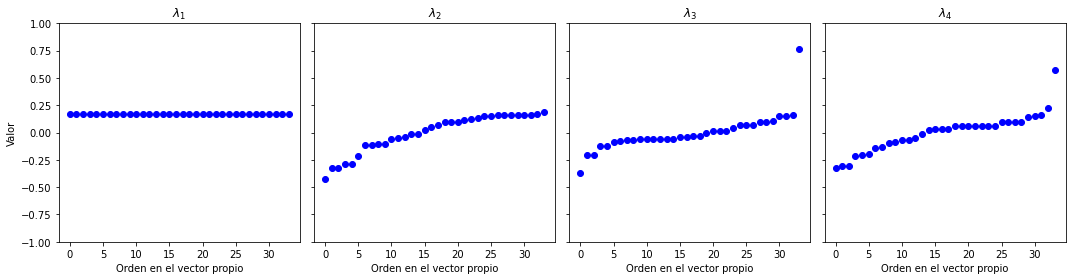

In [26]:
fig, axs = plt.subplots(1,4, figsize=(15, 4), sharey=True)

for i in range(4):
  axs[i].plot(np.sort(evec_karate[:, i]), 'bo')
  axs[i].set_ylim([-1,1])
  axs[i].set_xlabel('Orden en el vector propio')
  axs[i].set_title('$\\lambda_' + str(i + 1) + '$')

axs[0].set_ylabel('Valor')
fig.tight_layout()
plt.show()

Agrupamos los elementos del vector propio con valor propio más pequeño.

In [27]:
km_karate = KMeans(n_clusters=3, n_init=100)
km_karate = km_karate.fit(evec_karate[:, [1]])
km_karate.labels_

array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Visualizamos el agrupamiento de los vértices.

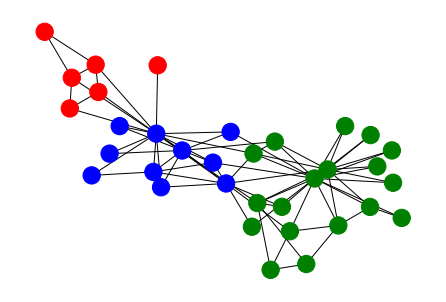

In [28]:
color_vertices = [mapa_color[km_karate.labels_[n]] for n in G_karate]
nx.draw(G_karate, pos=karate_pos, node_color=color_vertices)

## Detección de comunidades en _Facebook's Social circles_
Aplicamos agrupamiento espectral a los [círculos sociales de Facebook de SNAP](https://snap.stanford.edu/data/ego-Facebook.html).

Primero descargamos y desempaquetamos los datos.

In [29]:
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip facebook_combined.txt.gz

--2022-11-14 17:58:15--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   409KB/s    in 0.5s    

2022-11-14 17:58:16 (409 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]



Cargamos el grafo y lo visualizamos.

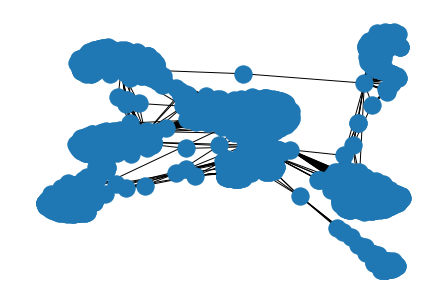

In [30]:
G_large = nx.read_edgelist('facebook_combined.txt')
large_pos = nx.spring_layout(G_large)
nx.draw(G_large, pos=large_pos)

Obtenemos su matriz laplaciana y le aplicamos agrupamiento espectral para obtener 10 comunidades

In [31]:
amat_large = nx.linalg.adjacency_matrix(G_large)
sc_large = SpectralClustering(n_clusters=10, 
                              affinity='precomputed', 
                              n_init=100)
sc_large = sc_large.fit(amat_large)

Visualizamos las comunidades

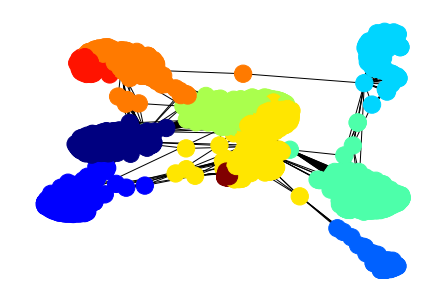

In [32]:
nx.draw(G_large, pos=large_pos, node_color=sc_large.labels_, cmap=plt.cm.jet)